In [175]:
import numpy as np
import torch
import torch.nn as nn
from PersonalTransformer import Transformer
import os
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import mido

torch.set_float32_matmul_precision('high')

Data Processing
---

This has been taken from "https://medium.com/analytics-vidhya/convert-midi-file-to-numpy-array-in-python-7d00531890c"

In [37]:
def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        result[note-21] = velocity if on_ else 0
    return result

def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]
def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

def mid2arry(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return np.array(all_arys[min(ends): max(ends)], dtype=bool)

def arry2mid(ary, tempo=500000):
    # get the difference
    new_ary = np.concatenate([np.array([[0] * 88]), np.array(ary)], axis=0)
    changes = new_ary[1:] - new_ary[:-1]
    # create a midi file with an empty track
    mid_new = mido.MidiFile()
    track = mido.MidiTrack()
    mid_new.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0))
    # add difference in the empty track
    last_time = 0
    for ch in changes:
        if set(ch) == {0}:  # no change
            last_time += 1
        else:
            on_notes = np.where(ch > 0)[0]
            on_notes_vol = ch[on_notes]
            off_notes = np.where(ch < 0)[0]
            first_ = True
            for n, v in zip(on_notes, on_notes_vol):
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_on', note=n + 21, velocity=v, time=new_time))
                first_ = False
            for n in off_notes:
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_off', note=n + 21, velocity=0, time=new_time))
                first_ = False
            last_time = 0
    return mid_new

In [39]:
folder_path = "/home/arnabdey/Projects/NLP/MIDI files"
all_files = os.listdir(folder_path)
for file_name in all_files:
    path = os.path.join(folder_path, file_name)
    mid = mido.MidiFile(path, clip=True)
    song = torch.tensor(mid2arry(mid=mid), dtype=torch.float32)
    target_labels = torch.argmax(song, dim=-1)
    break

The Model
---

In [185]:
seq_length = 256
myTransformer = Transformer(embd_dim=88, seq_length=seq_length, vocab_size=88, num_heads_decoder=8, num_heads_encoder=8)
myTransformer = torch.compile(myTransformer).to('cuda')

In [186]:
optimizer = optim.AdamW(params=myTransformer.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [188]:
Losses = []
for _ in range(3):
    for file_name in tqdm(all_files[:20]):
        path = os.path.join(folder_path, file_name)
        mid = mido.MidiFile(path, clip=True)
        song = np.array(mid2arry(mid=mid), dtype=np.float32)

        data = torch.tensor(np.array([song[i:i+seq_length] for i in range(len(song) - seq_length)]), dtype=torch.float32)

        dataset = TensorDataset(data)
        dataloader = DataLoader(dataset, batch_size=256)

        per_song_loss = 0.0
        for data in dataloader:
            data = data[0]
            
            start_token = torch.zeros(data.size(0), 1, data.size(2))  # Shape: (10, 1, 512)
            shifted_data = torch.cat([start_token, data[:, :-1, :]], dim=1)  # Shape: (10, 32, 512)

            data, shifted_data = data.to('cuda'), shifted_data.to('cuda')
            optimizer.zero_grad()
            logits = myTransformer(data, shifted_data)

            loss = criterion(logits, data)
            loss.backward()
            optimizer.step()
            per_song_loss += loss.item()
        Losses.append(per_song_loss)

100%|██████████| 20/20 [18:40<00:00, 56.01s/it]


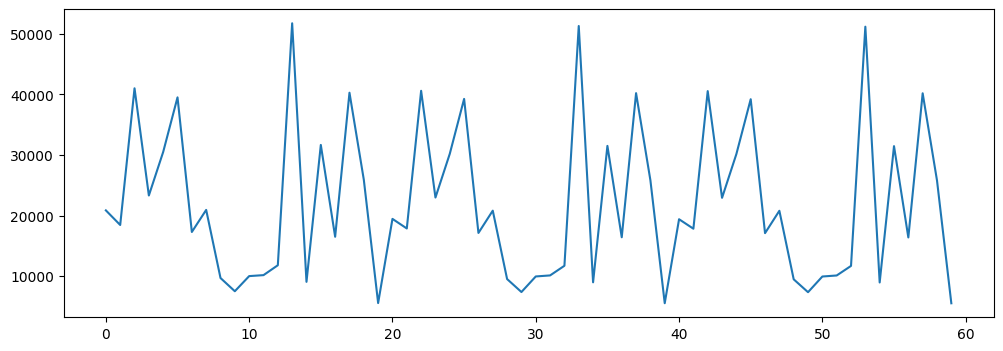

In [190]:
plt.figure(figsize=(12, 4))
plt.plot(Losses)
plt.show()

Create New Song
---

In [191]:
random_index = np.random.randint(low = 0, high=87, size=seq_length)
starting_notes = np.zeros((seq_length + 1, 88), dtype=np.float32)
starting_notes[np.arange(seq_length), random_index] = 1.0
encoded_notes = torch.tensor(starting_notes[:-1], dtype=torch.float32, device='cuda').unsqueeze(dim=0)
decoder_starter = torch.tensor(starting_notes[1:], dtype=torch.float32, device='cuda').unsqueeze(dim=0)

In [200]:
print(encoded_notes.shape)
start_token = torch.zeros((encoded_notes.size(0), 1, encoded_notes.size(2)), dtype=torch.float32, device='cuda')
decoder_starter = torch.cat([start_token, encoded_notes[:, :-1, :]], dim=1)
print(decoder_starter.shape)

torch.Size([1, 256, 88])
torch.Size([1, 256, 88])


In [202]:
generated_tokens = []
with torch.no_grad():
    E = myTransformer.encoder(encoded_notes)
    pass
    S = myTransformer.decoder(E, decoder_starter)
    for _ in tqdm(range(2000)):
        S = myTransformer.decoder(E, S)
        pred_note = S[0][-1]
        pred_note = torch.softmax(pred_note, dim=0)
        note = np.zeros(88, dtype=int)
        note[torch.argmax(pred_note)] = int(torch.max(pred_note) * 88)
        generated_tokens.append(note)
generated_tokens = np.array(generated_tokens)

100%|██████████| 2000/2000 [00:09<00:00, 207.75it/s]


In [126]:
generated_midi = arry2mid(generated_tokens)
generated_midi.save("NewMusic.mid")